# TUTORIAL 3 2020 MEMO

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from PyAstronomy.pyTiming import pyPDM 
import pandas as pd

## Question 1
#### 1.1 Write your own implementation of the PDM routine

In [2]:
 def myPDM(t,y,periods,nbins):
        # Here x is the time stamps, y is the values, and periods is an array of periods on which to fold data
        # calculate global stdev
        g_var = np.var(y)
        g_mean = np.mean(y)
        bwidth = 1.0/nbins
        
        # This is going to be the variable I return
        Q = np.zeros(len(periods))
        
        # for each period in the test range, fold the data and calculate the test stat
        for i in range(len(periods)):
            # make the phase array
            phase = ((t - t[0])%periods[i])/periods[i]
            
            bin_no = np.zeros(len(y))

            # do the bin allocation in a for loop
            for j in range(len(y)):
                n = int(phase[j] / bwidth) # calculate bin number for this value
                bin_no[j] = n
            
            
             #Now that the bins are allocated, you can just index 
            #them by the bin numbers to get the relevant statistics   

            n_z = np.zeros(nbins)
            sig_z = np.zeros(nbins)
            my_sum = 0
            
            for z in range(nbins):
                idx = np.where(bin_no == z)
                # WHAT IF YOU'VE GOT ONE or NO POINTS IN A BIN? That's what if statement is for
                
                if (np.size(idx) > 1):
                    n_z[z] = np.size(idx)
                    sig_z[z] = np.var(y[idx])
                else:
                    n_z[z] = 0
                    sig_z[z] = 0
                    
                #my_sum += (n_z[z] - 1)*sig_z[z]/(n_z[z] - nbins)
                #print(my_sum)
            #Now the bins are populated. Let's do the sum
            s_sq = (np.dot(n_z,sig_z))/(np.sum(n_z) - nbins) 
            
            # calculate Qsq
            #Q[i] = my_sum/(g_var)#*(len(y)-nbins))
            Q[i] = s_sq/g_var
        
        # return Qsq 
        return Q
        

#### 1.2 Run it on the sunspot data

In [3]:
date,num = np.loadtxt("../data_and_plots/zuerich-monthly-sunspot-numbers-.csv",
                 skiprows=1,dtype= str, delimiter=",",unpack=True)

yr = np.zeros(len(date))
num = np.array(num,dtype = float)

for i in range(len(date)):
    a,b = date[i].strip("\"").split("-")
    yr[i] = float(a) + float(b)/12

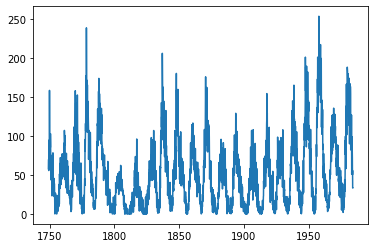

In [4]:
plt.plot(yr,num)
plt.show()

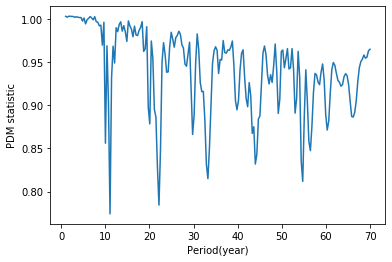

In [5]:
ss_per = np.linspace(1,70,200)
ss_Qsq = myPDM(yr,num,ss_per,10)

plt.plot(ss_per,ss_Qsq)
plt.xlabel("Period(year)")
plt.ylabel("PDM statistic")
plt.show()

__1.3 PDM implementation from PyAstronomy__

In [6]:
scanner = pyPDM.Scanner(minVal=1, maxVal=70, dVal=0.35, mode="period")
print(scanner)

ss_P = pyPDM.PyPDM(yr, num)
f2, t2 = ss_P.pdmEquiBin(10, scanner)

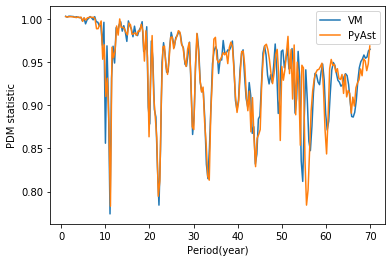

In [7]:
plt.plot(ss_per,ss_Qsq)
plt.plot(f2,t2)
plt.legend(["VM","PyAst"])
plt.xlabel("Period(year)")
plt.ylabel("PDM statistic")
plt.show()

Both routines show the lowest value of the PDM statistic around 11 year, consistent with the soalr cycle. The routines diverge somewhat at larger test periods, which is due to a difference in the sampling of those periods.

## Question 2 
#### 2.1 Read in event data of the magenetar and plot the lightcurve  

In [8]:
myevts = pd.read_csv('../data_and_plots/acisf14329N002_evt2_reg_filtered.txt',delim_whitespace=True, skiprows = 4,
                 names = ["num","time","energy"])

In [9]:
pd.DataFrame(myevts)

,num,time,energy
0,1,4.304152e+08,3829.9438
1,2,4.304153e+08,2650.3792
2,3,4.304153e+08,4852.3169
3,4,4.304153e+08,6660.8247
4,5,4.304153e+08,3799.8506
...,...,...,...
1061,1062,4.304295e+08,2922.2610
1062,1063,4.304295e+08,5992.8862
1063,1064,4.304296e+08,5580.2393
1064,1065,4.304296e+08,3469.1802


To plot the lightcurve we need to bin up the time stamps.

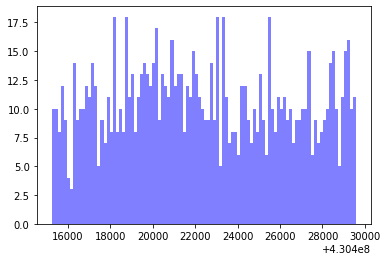

In [10]:
#There are just over 1000 events in the file, lets bin them into 100 equally spaced time bins
num_bins=100
n, bins, patches = plt.hist(myevts.time, num_bins, facecolor='blue', alpha=0.5)

In [11]:
binsize = (bins[1]-bins[0]) # binsize in seconds
count_rate = n/binsize #We want some measure of the brightness, counts/second will do
bin_middle = bins[0:-1] + binsize

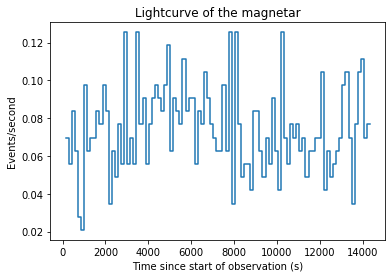

In [12]:
plt.step(bin_middle - bins[0],count_rate,)
plt.xlabel("Time since start of observation (s)")
plt.ylabel("Events/second")
plt.title("Lightcurve of the magnetar")
plt.show()

### 2.2 Z$^2$ statistic and plot

In [13]:
test_freq = np.linspace(0.05, 1, num=10000)

n = len(myevts.time)

z2 = np.zeros(len(test_freq))
i = 0

# Loop across the test frequencies
for tf in test_freq:
    
    # Phase events at this specific tf:
    phase = (tf * myevts.time)%1 
    
    # Calculate Z^2
    # First convert our phase angle into radians
    term1 = (sum(np.cos(phase*2*np.pi)))**2
    term2 = (sum(np.sin(phase*2*np.pi)))**2         
    z2[i] = 2*(term1 + term2)/n
    
    #Increase the counter
    i += 1

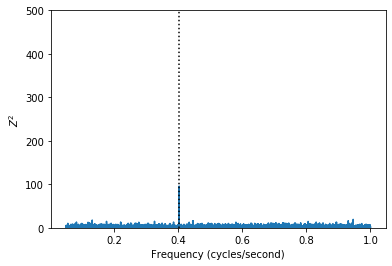

In [14]:
plt.plot(test_freq,z2)
plt.ylim([0,500])
plt.xlabel("Frequency (cycles/second)")
plt.ylabel("$Z^2$")
plt.axvline(1/2.48,ls=':',color='black')
plt.show()

I noticed that I can detected the 2.48s period if I used either 1000 or 10000 samples between 1 and 20 seconds. If I used 5000 test periods, then I miss it!!

## Question 3: Non-Fourier methods

All three these methods rely on folding the time series or event data on trial periods and then calculating a statistic for each trial period. The differences between them are simply in the statistcs that are calculated for each method. Epoch folding and minimum string length both use the means (one in comparison with the global mean and the other in comparison with a mean in an adjacent bin) while PDM uses the variance.


## Question 4: Dynamic periodograms
### 4.1 Dynamic periodogram of Her X-1

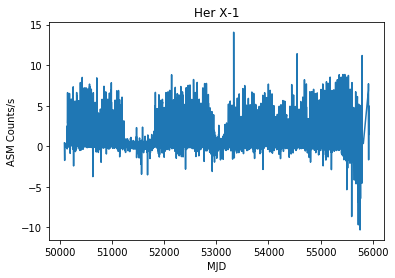

In [15]:
herx1=pd.read_csv('../data_and_plots/herx1_asm.txt',delim_whitespace=True, skiprows = 5,
                 names = ["mjd","rate","raterr"])

plt.plot(herx1.mjd,herx1.rate)
plt.xlabel("MJD")
plt.ylabel("ASM Counts/s")
plt.title("Her X-1")
plt.show()

In [16]:
t = herx1.mjd
c = herx1.rate

In [17]:
# Step through the data stream in 50 day steps, taking 200 day chunks
# at each step

delta_t = 200
jitter_t = 50


# Choose the frequency array 
df = 1/(10*200)
freq = np.arange(1/100., 1/10, 0.001)

# This is supposed to be an array of arrays in which to keep the power
power = []
tstart = []

i=0
t_start = t[0]
while (t_start + delta_t < t[len(t)-1]):
    
    if i==0: t_start = t[0]
    
    # Select the bit of the time series to use for the periodogram
    t_short = t[np.logical_and(t>=t_start, t<(t_start+delta_t))]
    c_short = c[np.logical_and(t>=t_start, t<(t_start+delta_t))]
    
    # Run the Lomb Scargle
    p = LombScargle(t_short, c_short).power(freq)
       
    # Append the power and the start time  
    power.append(p)
    tstart.append(t_start)
    
    # reset i and tstart
    i = i + 1
    t_start = t_start + jitter_t

### 4.2 Visualise the dynamic power spectrum

In [18]:
print(len(tstart))
print(len(freq))

113
91


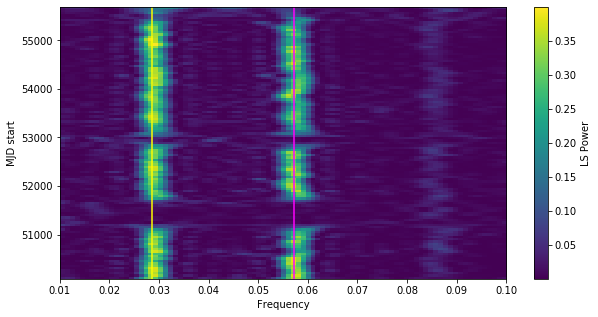

In [19]:
ax = plt.subplots(figsize=(10, 5))
plt.subplot(111)
plt.imshow(power, interpolation='none', extent=[freq[0],freq[90],tstart[0],tstart[112]], 
           aspect='auto',origin="lower")
plt.xlabel("Frequency")
plt.ylabel("MJD start")
plt.colorbar(label="LS Power")
plt.axvline(2/35,color="magenta")
plt.axvline(1/35,color="yellow")
#plt.axis(1/100., 1/21., tstart[0], tstart[len(tstart)-1])
plt.show()

### 4.3 Time evolution of the 35 day period
The 35 day period (in yellow) and its harmonic (pink) are visible throughout most of the dataset. There are no large variations in the 35 day period over time.